# Heat conduction in a two-partitioned rectangular domain

https://github.com/precice/tutorials/tree/master/partitioned-heat-conduction

## Summary
We solve a simple heat equation. The domain is partitioned and the coupling is established in a Dirichlet-Neumann fashion.

## Setup

We solve a partitioned heat equation. For information on the non-partitioned case, please refer to [1, p.37ff]. In this tutorial the computational domain is partitioned and coupled via preCICE. The coupling roughly follows the approach described in [2].

![Case setup of partitioned-heat-conduction case](images/tutorials-partitioned-heat-conduction-setup.png)

Case setup from [3]. `D` denotes the Dirichlet participant and `N` denotes the Neumann participant.

The heat equation is solved on a rectangular domain `Omega = [0,2] x [0,1]` with given Dirichlet boundary conditions. We split the domain at `x_c = 1` using a straight vertical line, the coupling interface. The left part of the domain will be referred to as the Dirichlet partition and the right part as the Neumann partition. To couple the two participants we use Dirichlet-Neumann coupling. Here, the Dirichlet participant receives Dirichlet boundary conditions (`Temperature`) at the coupling interface and solves the heat equation using these boundary conditions on the left part of the domain. Then the Dirichlet participant computes the resulting heat flux (`Flux`) from the solution and sends it to the Neumann participant. The Neumann participant uses the flux as a Neumann boundary condition to solve the heat equation on the right part of the domain. We then extract the temperature from the solution and send it back to the Dirichlet participant. This establishes the coupling between the two participants.

This simple case allows us to compare the solution for the partitioned case to a known analytical solution (method of manufactures solutions, see [1, p.37ff]). For more usage examples and details, please refer to [3, sect. 4.1].

In [1]:
from pyiron_continuum import Project

In [2]:
pr = Project('partitioned_heat_conduction')
pr.remove_jobs(silently=True, recursive=True)

  0%|          | 0/3 [00:00<?, ?it/s]

## Dirichlet partition

In [3]:
job_d = pr.create.job.Fenics('fenics_drichlet')

/home/muhammad/workspace/gitRepo/pyiron-repos/pyiron_continuum/notebooks/pyiron_continuum/fenics/job/generic.py:129: UserWarning: Currently, the c++ dolfin functions used by fenics are not stored in the HDF5 file. This includes the domains, boundary condition, spatial functions. Therefore, it is not possible to reload the job properly, from HDF5 file. It would be safe to remove the Fenics jobs, after defining the project.
  warnings.warn("Currently, the c++ dolfin functions used by fenics are not stored in the HDF5 file."


### The domain and mesh

In [4]:
y_bottom, y_top = 0, 1
x_left, x_right = 0, 2
x_coupling = 1.0  # x coordinate of coupling interface
radius = 0.2
nx = ny = 9
alpha = 3  # parameter alpha
beta = 1.3  # parameter beta

In [5]:
job_d.input.element_order

2

In [6]:
job_d.input.element_type

'P'

In [7]:
job_d.domain.mesh.regular.rectangle((x_left, y_bottom), (x_coupling, y_top), nx, ny, diagonal="left")

In [8]:
job_d.domain.mesh()

### Defining the coupled and non-coupled boundaries

#### Non-coupled boundary
Dirichlet boundary at the non-coupled boundaries, based on the expression `u_D`:

In [9]:
conditions_non_coupling = 'not near(x[0], 1.0, 1E-14) \
                                    or near(x[1], 1.0, 1E-14) or near(x[1], 0., 1E-14)'   
job_d.domain.subdomain(name='non_coupling_boundary', conditions=conditions_non_coupling)

In [10]:
u_analytical = job_d.Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t', degree=2, alpha=alpha, beta=beta, t=0)
job_d.domain.boundary(bc_type='dirichlet', subdomain_name='non_coupling_boundary', expression=u_analytical)

#### Coupled subdomain

In [11]:
conditions_coupling_bc = 'near(x[0], 1.0, 1E-14)'
job_d.domain.subdomain(name='coupling_boundary', conditions=conditions_coupling_bc)

In [12]:
job_d.domain.list_subdomains()

{'non_coupling_boundary': <pyiron_continuum.fenics.factory.FenicsSubDomain at 0x7f71cc33a310>,
 'coupling_boundary': <pyiron_continuum.fenics.factory.FenicsSubDomain at 0x7f7145806ea0>}

### PDE equation

In [13]:
job_d.input.dt = 0.1

In [14]:
job_d.input

DataContainer({'mesh_resolution': 2, 'element_type': 'P', 'element_order': 2, 'n_steps': 1, 'n_print': 1, 'dt': 0.1, 'solver_parameters': {}})

#### Initial Condition

In [15]:
job_d.solver.set_initial_condition(interpolate=True, expression=u_analytical)

The intial value will be assigned to 'u_n'!


In [16]:
job_d.solver.u_n.rename("Temperature", "")

In [17]:
#job_d.solver.set_expression(key='f', expression='beta - 2 - 2*alpha', degree=2, alpha=alpha, beta=beta)
job_d.solver.f = job_d.Constant(u_analytical.beta - 2 - 2*u_analytical.alpha)

In [18]:
job_d.solver.f

Coefficient(FunctionSpace(None, FiniteElement('Real', None, 0)), 19)

In [19]:
job_d.solver.F = 'u * v / dt * dx + dot(grad(u), grad(v)) * dx - (u_n / dt + f) * v * dx'
job_d.solver.solution.rename("Temperature", "")
job_d.solver.time_dependent_expressions.append(u_analytical)

### Precice Adaptor configuration

In [20]:
flux_normal_interpolated = job_d.solver.interpolate(function_space=job_d.solver.V_g.sub(0).collapse(),
                                                    expression="2 * x[0]", degree=1)

In [21]:
job_d.init_adapter_conf(config_file='precice_config/precice-adapter-config-D.json', coupling_boundary_subdomain='coupling_boundary',
                                                    write_object=flux_normal_interpolated)

In [22]:
#job_d.adapter_conf.predefined_coupling(coupling_type='Dirichlet', flux_direction='x')
def update_coupling_dirichlet(coupling_expression, coupling_boundary, job):
    job.domain.boundary(bc_type='dirichlet', subdomain_name=coupling_boundary, expression=coupling_expression)

def coupling_data_dirichlet(config, job):
    job.solver.flux.rename("Flux", "")
    job.solver.calc_flux()
    flux_x = job.solver.interpolate(job.solver.flux.sub(0), function_space=config.write_object.function_space())
    return flux_x

job_d.adapter_conf.update_boundary_func = update_coupling_dirichlet
job_d.adapter_conf.coupling_data_func = coupling_data_dirichlet




## Neumann Partition

In [23]:
job_n = pr.create.job.Fenics('fenics_neumann')

In [24]:
job_n.domain.mesh.regular.rectangle((x_left, y_bottom), (x_coupling, y_top), nx, ny, diagonal="left")

In [25]:
u_analytical_n = job_n.Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t', degree=2, alpha=alpha, beta=beta, t=0)

In [26]:
job_n.domain.subdomain(name='non_coupling_boundary', conditions=conditions_non_coupling)
job_n.domain.boundary(bc_type='dirichlet', subdomain_name='non_coupling_boundary', expression=u_analytical_n)

In [27]:
job_n.domain.subdomain(name='coupling_boundary', conditions=conditions_coupling_bc)

In [28]:
job_n.input.dt = 0.1

In [29]:
job_n.solver.set_initial_condition(interpolate=True, expression=u_analytical_n)
job_n.solver.u_n.rename("Temperature", "")
job_n.solver.time_dependent_expressions.append(u_analytical_n)

The intial value will be assigned to 'u_n'!


In [30]:
#job_n.solver.set_expression(key='f', expression='beta - 2 - 2*alpha', degree=2, alpha=alpha, beta=beta)
job_n.solver.f = job_n.Constant(u_analytical_n.beta - 2 - 2*u_analytical_n.alpha)

In [31]:
job_n.solver.f

Coefficient(FunctionSpace(None, FiniteElement('Real', None, 0)), 47)

In [32]:
job_n.solver.F = 'u * v / dt * dx + dot(grad(u), grad(v)) * dx - (u_n / dt + f) * v * dx'

In [33]:
job_n.solution.rename("Temperature", "")

In [34]:
u_analytical_interpolated = job_n.solver.interpolate(expression=u_analytical_n)

In [35]:
job_n.init_adapter_conf(config_file='precice_config/precice-adapter-config-N.json', coupling_boundary_subdomain='coupling_boundary',
                                                    write_object=u_analytical_interpolated,  function_space=job_n.solver.V_g.sub(0).collapse())

In [36]:
#job_n.adapter_conf.predefined_coupling(coupling_type="Neumann")
def update_coupling_neumann(coupling_expression, coupling_boundary, job):
    job.solver.F += job.solver.v * coupling_expression * job.ds

def coupling_data_neumann(config, job):
    return job.solver.solution

In [37]:
job_n.adapter_conf.update_boundary_func = update_coupling_neumann
job_n.adapter_conf.coupling_data_func = coupling_data_neumann

### Creating Precice job

In [38]:
job_p = pr.create.job.Precice('precice_parent')

**Appending fenics jobs as child job to the precice job**

In [39]:
job_p.child_list.append(job_d)
job_p.child_list.append(job_n)

**Running the precice job**

In [40]:
job_p.run()

The job precice_parent was saved and received the ID: 30
The job fenics_drichlet was saved and received the ID: 31
The job fenics_neumann was saved and received the ID: 32
---[precice]  This is preCICE version 2.3.0
---[precice]  Revision info: no-info [Git failed/Not a repository]
---[precice]  Configuration: Debug
---[precice]  Configuring preCICE with configuration "/home/muhammad/workspace/gitRepo/pyiron-repos/pyiron_continuum/notebooks/precice_config/precice-config.xml"
---[precice]  I am participant "Dirichlet"
---[precice]  This is preCICE version 2.3.0
---[precice]  Revision info: no-info [Git failed/Not a repository]
---[precice]  Configuration: Debug
---[precice]  Configuring preCICE with configuration "/home/muhammad/workspace/gitRepo/pyiron-repos/pyiron_continuum/notebooks/precice_config/precice-config.xml"
---[precice]  I am participant "Neumann"
---[precice]  Setting up master communication to coupling partner/s
---[precice]  Setting up master communication to coupling pa

In [41]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,30,finished,None,precice_parent,/precice_parent,/home/muhammad/,workspace/gitRepo/pyiron-repos/pyiron_continuum/notebooks/partitioned_heat_conduction/,2022-02-19 22:28:26.797079,NaT,NaN,pyiron@cmleo14#1,Precice,0.4,None,None
1,31,finished,None,fenics_drichlet,/fenics_drichlet,/home/muhammad/,workspace/gitRepo/pyiron-repos/pyiron_continuum/notebooks/partitioned_heat_conduction/,2022-02-19 22:28:26.992515,2022-02-19 22:28:29.763984,2.0,pyiron@cmleo14#1,Fenics,0.4,None,None
2,32,finished,None,fenics_neumann,/fenics_neumann,/home/muhammad/,workspace/gitRepo/pyiron-repos/pyiron_continuum/notebooks/partitioned_heat_conduction/,2022-02-19 22:28:27.006138,2022-02-19 22:28:29.773518,2.0,pyiron@cmleo14#1,Fenics,0.4,None,None


In [42]:
import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')

_XSERVTransmkdir: Owner of /tmp/.X11-unix should be set to root


In [43]:
import pyvista as pv

In [44]:
mesh_d = pv.read("out/Dirichlet000010.vtu")
mesh_n = pv.read("out/Neumann000010.vtu")

In [45]:
mesh_n

UnstructuredGrid (0x7f71445a2820)
  N Cells:	162
  N Points:	100
  X Bounds:	1.000e+00, 2.000e+00
  Y Bounds:	0.000e+00, 1.000e+00
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	1

In [48]:
mesh_d.plot(scalars='Temperature')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [49]:
mesh_n.plot(scalars='Temperature')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [50]:
p = pv.Plotter()
p.add_mesh(mesh_n, clim=[2.30, 6.30])
p.add_mesh(mesh_d, clim=[2.30, 6.30])
#_ = p.add_axes(line_width=5, labels_off=True)
#_ = p.add_axes_at_origin(line_width=0.5)
p.view_xy()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [51]:
result = mesh_n + mesh_d

In [52]:
a = [result.bounds[0], result.bounds[2], result.bounds[4]]
b = [result.bounds[1], result.bounds[3], result.bounds[5]]


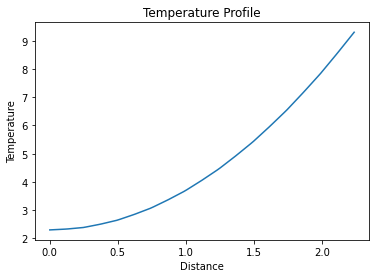

In [53]:
result.plot_over_line(a, b, resolution=100)